Imports

In [1081]:
import pandas as pd
import numpy as np
from pyomo.environ import * 
from pyomo.opt import SolverFactory
import folium
import csv
import random  
import copy
from collections import Counter

Cargar archivos requerido por la instancia

In [1082]:
clients_df = pd.read_csv("Proyecto_Caso_Base/clients.csv")
depots_df = pd.read_csv("Proyecto_Caso_Base/depots.csv")
vehicles_df = pd.read_csv("Proyecto_Caso_Base/vehicles.csv")


In [1083]:
print(clients_df)
print(depots_df)
print(vehicles_df)
capacidad_maxima = vehicles_df['Capacity'].max()

vehicles_df['Capacity'] = capacidad_maxima

    ClientID  LocationID  Demand  Longitude  Latitude
0          1           2      13 -74.098938  4.597954
1          2           3      15 -74.075571  4.687821
2          3           4      12 -74.107085  4.709494
3          4           5      15 -74.097280  4.605029
4          5           6      20 -74.164641  4.648464
5          6           7      17 -74.120838  4.662137
6          7           8      17 -74.022131  4.697499
7          8           9      20 -74.172075  4.649417
8          9          10      20 -74.156153  4.606311
9         10          11      15 -74.090411  4.557380
10        11          12      17 -74.178023  4.591594
11        12          13      12 -74.101541  4.756417
12        13          14      21 -74.096909  4.646217
13        14          15      15 -74.121920  4.725912
14        15          16      17 -74.094295  4.604168
15        16          17      10 -74.111388  4.557321
16        17          18      25 -74.124639  4.615869
17        18          19    

In [1084]:
C=list(depots_df["DepotID"])
CAP=dict(zip(depots_df["DepotID"],depots_df["Capacity"]))

In [1085]:
print("Conjunto C:", C)
print("Capacidades CAP_i:", CAP)

Conjunto C: [1]
Capacidades CAP_i: {1: 90}


In [1086]:
K=list(clients_df["ClientID"])
DEM=dict(zip(clients_df["ClientID"],clients_df["Demand"])) 
COORDENADAS_CLIENTES=dict(zip(clients_df["ClientID"],zip(clients_df["Longitude"],clients_df["Latitude"])))

In [1087]:
print("Conjunto K: clientes", K)
print("Capacidades Demanda:", DEM)
print("Coordenadas clientes:", COORDENADAS_CLIENTES)

Conjunto K: clientes [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Capacidades Demanda: {1: 13, 2: 15, 3: 12, 4: 15, 5: 20, 6: 17, 7: 17, 8: 20, 9: 20, 10: 15, 11: 17, 12: 12, 13: 21, 14: 15, 15: 17, 16: 10, 17: 25, 18: 12, 19: 11, 20: 15, 21: 14, 22: 18, 23: 15, 24: 11}
Coordenadas clientes: {1: (-74.09893796560621, 4.59795431125545), 2: (-74.07557103763986, 4.687820646838871), 3: (-74.10708524062704, 4.70949446000624), 4: (-74.09727965657427, 4.605029068682624), 5: (-74.16464148202755, 4.648463876533332), 6: (-74.12083799988112, 4.662137416953968), 7: (-74.02213076607309, 4.697499030379109), 8: (-74.17207549744595, 4.649416884236942), 9: (-74.15615257246444, 4.606310650273935), 10: (-74.09041145358674, 4.557379705282216), 11: (-74.17802255204528, 4.591594072172954), 12: (-74.1015410917749, 4.7564172406324055), 13: (-74.09690889182339, 4.646217006050524), 14: (-74.1219200708342, 4.725912125314368), 15: (-74.0942948461378, 4.604168478560718), 1

Distancia harvesiana

In [1088]:
def dist_haversiana(lon1,lat1,lon2,lat2):
  R=6371.0 #radio tierra
  lon1,lat1,lon2,lat2=map(np.radians,[lon1,lat1,lon2,lat2])
  dlon=lon2-lon1
  dlat=lat2-lat1
  a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
  c = 2 * np.arcsin(np.sqrt(a))
  return R * c

In [1089]:
DIST={}
for i,depot in depots_df.iterrows():
  for j,client in clients_df.iterrows():
    di=depot["DepotID"]
    ci=client["ClientID"]
    distance=dist_haversiana(depot["Longitude"],depot["Latitude"],
                             client["Longitude"],client["Latitude"]
                             )
    DIST[(di,ci)]=round(distance,2)

In [1090]:
for key, val in list(DIST.items())[:5]:
  print("La distancia entre el centro de distribucion", key[0], "y el cliente", key[1], "es de", val)

La distancia entre el centro de distribucion 1.0 y el cliente 1.0 es de 17.26
La distancia entre el centro de distribucion 1.0 y el cliente 2.0 es de 10.62
La distancia entre el centro de distribucion 1.0 y el cliente 3.0 es de 6.38
La distancia entre el centro de distribucion 1.0 y el cliente 4.0 es de 16.6
La distancia entre el centro de distribucion 1.0 y el cliente 5.0 es de 10.62


In [1091]:
V=list(vehicles_df.index)
Q = dict(zip(V, vehicles_df["Capacity"]))


R = dict(zip(V, vehicles_df["Range"]))

In [1092]:
print("Vehículos:", V)
print("Capacidades:", Q)
print("Rangos:", R)

Vehículos: [0, 1, 2, 3, 4, 5, 6, 7]
Capacidades: {0: 140, 1: 140, 2: 140, 3: 140, 4: 140, 5: 140, 6: 140, 7: 140}
Rangos: {0: 170, 1: 200, 2: 180, 3: 90, 4: 100, 5: 170, 6: 150, 7: 140}


In [1093]:
for v in V:
    print(f"vehiculo {v}: Tipo={vehicles_df['VehicleType'][v]}, Capacidad={Q[v]}, Rango={R[v]}")

vehiculo 0: Tipo=Gas Car, Capacidad=140, Rango=170
vehiculo 1: Tipo=Gas Car, Capacidad=140, Rango=200
vehiculo 2: Tipo=Gas Car, Capacidad=140, Rango=180
vehiculo 3: Tipo=Gas Car, Capacidad=140, Rango=90
vehiculo 4: Tipo=Gas Car, Capacidad=140, Rango=100
vehiculo 5: Tipo=Gas Car, Capacidad=140, Rango=170
vehiculo 6: Tipo=Gas Car, Capacidad=140, Rango=150
vehiculo 7: Tipo=Gas Car, Capacidad=140, Rango=140


Implementar metodo metaheurístico: Algorimo genético 

Parametros

In [1094]:
pupulation_size = 120
max_generations = 200
crossover_rate = 0.6
mutation_rate = 0.4
elitism_count = 4

Inicialización de la población

La población es el conjunto de individuos que representan posibles soluciones. En este caso un individuo representa una forma distinta de asignar clientes a vehículos, definir el orden de visita de esos clientes por vehículo y respetar la capacidad del vehículo.

In [1095]:
def repair_individual(individual, all_clients, capacities, demands):
    # Aplanar rutas y contar visitas
    flat = sum(individual, [])
    count = Counter(flat)

    # Detectar clientes faltantes
    missing = [c for c in all_clients if count[c] == 0]

    # Eliminar duplicados (mantener primera aparición)
    seen = set()
    cleaned_routes = []
    for route in individual:
        new_route = []
        for c in route:
            if c not in seen:
                new_route.append(c)
                seen.add(c)
        if new_route:
            cleaned_routes.append(new_route)

    # Añadir clientes faltantes intentando respetar capacidades
    for client in missing:
        added = False
        for idx, route in enumerate(cleaned_routes):
            cap = capacities[min(idx, len(capacities) - 1)]
            load = sum(demands[c] for c in route)
            if load + demands[client] <= cap:
                route.append(client)
                added = True
                break
        if not added:
            cleaned_routes.append([client])

    return [r for r in cleaned_routes if r]



def inicializar_poblacion(poblacion_size, clients, cap_vehiculos, dem_clients):
    poblacion = []

    for _ in range(poblacion_size):
        clientes_barajados = clients.copy()
        random.shuffle(clientes_barajados)

        individuo = [[] for _ in cap_vehiculos]  # una ruta por cada vehículo
        cargas = [0 for _ in cap_vehiculos]

        for cliente in clientes_barajados:
            demanda = dem_clients[cliente]
            posibles = []

            # Buscar rutas con suficiente capacidad restante
            for idx, capacidad in enumerate(cap_vehiculos):
                if cargas[idx] + demanda <= capacidad:
                    posibles.append(idx)

            if posibles:
                # Asignar a una ruta aleatoria con capacidad disponible
                elegido = random.choice(posibles)
                individuo[elegido].append(cliente)
                cargas[elegido] += demanda
            else:
                # Si no hay ninguna ruta válida, crear una nueva (si está permitido)
                # Suponemos que se puede añadir una nueva ruta si faltan clientes
                individuo.append([cliente])
                cargas.append(demanda)
                cap_vehiculos.append(max(cap_vehiculos))  # o una capacidad estándar

        # Eliminar rutas vacías
        individuo = [ruta for ruta in individuo if ruta]
        poblacion.append(individuo)

    return poblacion


def fitness(individual, distancias, deposito_id, coords_clientes, cap_vehiculos, dem_clients, clients, rango_vehiculos):
    costo_total = 0
    penalizacion = 0
    Pf = 123.12  # COP/km (combustible)
    Ft = 823     # COP/km (flete)
    Cm = 700     # COP/km (mantenimiento)

    # Validar que cada cliente es visitado exactamente una vez
    # y que no se repiten de lo contrario se penaliza
    clientes_visitados = sum(individual, [])  # aplanar rutas
    conteo = Counter(clientes_visitados)

    for c in clients:
        if conteo[c] != 1: 
            penalizacion += 1000 * abs(conteo[c] - 1)

    # Recorrer cada ruta (vehículo)
    for idx, ruta in enumerate(individual):
        if not ruta:
            continue

        # Restricción de capacidad del vehículo
        carga = sum(dem_clients[c] for c in ruta)
        if carga > cap_vehiculos[min(idx, len(cap_vehiculos)-1)]:
            penalizacion += 1000 * (carga - cap_vehiculos[min(idx, len(cap_vehiculos)-1)])

        # Calcular la distancia total de esta ruta
        distancia_total = 0
        distancia_total += distancias[(deposito_id, ruta[0])]  

        for i in range(len(ruta) - 1):
            c1, c2 = ruta[i], ruta[i+1]
            lon1, lat1 = coords_clientes[c1]
            lon2, lat2 = coords_clientes[c2]
            distancia_total += dist_haversiana(lon1, lat1, lon2, lat2)

        distancia_total += distancias[(deposito_id, ruta[-1])] 

        costo_total += distancia_total

        # Restriccion para que no se exceda el rango 
        # permitido
        if distancia_total > rango_vehiculos[min(idx, len(rango_vehiculos)-1)]:
            penalizacion += 1000 * (distancia_total - rango_vehiculos[min(idx, len(rango_vehiculos)-1)])
    
    costo_total *= (Pf + Ft + Cm)  


    return costo_total + penalizacion, costo_total, penalizacion


def seleccion_torneo(population, fitness_scores, k=2):
    selected = []
    for _ in range(len(population)):
        indices = random.sample(range(len(population)), k)
        mejor_idx = min(indices, key=lambda i: fitness_scores[i])
        selected.append(copy.deepcopy(population[mejor_idx]))
    return selected

def crossover_rutas(p1, p2):
    hijo1, hijo2 = [], []

    split1 = random.randint(0, len(p1)-1)
    split2 = random.randint(0, len(p2)-1)

    r1 = p1[:split1]
    r2 = p2[split2:]

    flat_r1 = set(sum(r1, []))
    flat_r2 = set(sum(r2, []))

    restantes1 = [c for ruta in p2 for c in ruta if c not in flat_r1]
    restantes2 = [c for ruta in p1 for c in ruta if c not in flat_r2]

    hijo1 = r1 + [restantes1]
    hijo2 = r2 + [restantes2]

    return hijo1, hijo2

def mutar_individuo(individual):
    rutas_validas = [ruta for ruta in individual if len(ruta) >= 1]
    if len(rutas_validas) < 2:
        return

    r1, r2 = random.sample(rutas_validas, 2)
    i1 = random.randint(0, len(r1) - 1)
    i2 = random.randint(0, len(r2) - 1)
    r1[i1], r2[i2] = r2[i2], r1[i1]



# K clientes 
# Q capacidades de los vehiculos
# DEM demanda de los clientes
cap_vehiculos_transform = [Q[v] for v in V] 
population = inicializar_poblacion(pupulation_size, K, cap_vehiculos_transform, DEM)


# print("K",K)
print("CAP",cap_vehiculos_transform)
print("DEM",DEM)
print("cap vehiculos",)


DIST_correctos_ids = {(int(i), int(j)): float(d) for (i, j), d in DIST.items()}
rango_vehiculos = [R[v] for v in V]  # igual que cap_vehiculos
print("Rango vehiculos: ", rango_vehiculos)

print("Debug inicial:")
for i, ind in enumerate(population[:5]):
    fit, costo, penal = fitness(ind, DIST_correctos_ids, 1, COORDENADAS_CLIENTES, cap_vehiculos_transform, DEM, clients_df["ClientID"].tolist(), rango_vehiculos)
    print(f"Ind {i}: fitness total = {fit}, costo real = {costo}, penalización = {penal}")

# Evaluar la población inicial
fitness_scores = [
    fitness(ind, DIST_correctos_ids, 1, COORDENADAS_CLIENTES, cap_vehiculos_transform, DEM, clients_df["ClientID"].tolist(), rango_vehiculos)
    for ind in population
]

# print("Poblacion inicial: ", population)
# print("Fitness scores: ", fitness_scores)

mejores_por_generacion = []

for generation in range(max_generations):
    # Selección
    mating_pool = seleccion_torneo(population, fitness_scores)

    # Cruce
    offspring = []
    for _ in range((pupulation_size - elitism_count) // 2):
        p1, p2 = random.sample(mating_pool, 2)
        if random.random() < crossover_rate:
            h1, h2 = crossover_rutas(p1, p2)
        else:
            h1, h2 = p1.copy(), p2.copy()
        h1_repaired = repair_individual(h1, K, cap_vehiculos_transform, DEM)
        h2_repaired = repair_individual(h2, K, cap_vehiculos_transform, DEM)
        offspring.extend([h1_repaired, h2_repaired])

    # Mutación
    for idx in range(len(offspring)):
        if random.random() < mutation_rate:
            mutar_individuo(offspring[idx])
            # Repara el individuo después de la mutación
            offspring[idx] = repair_individual(offspring[idx], K, cap_vehiculos_transform, DEM)

    # Evaluar descendencia
    # Evaluar descendencia
    offspring_fitness = [
        fitness(ind, DIST_correctos_ids, 1, COORDENADAS_CLIENTES, cap_vehiculos_transform, DEM, clients_df["ClientID"].tolist(), rango_vehiculos)
        for ind in offspring
    ]

    # Elitismo sobre población actual
    elite_indices = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i])[:elitism_count]
    elites = [copy.deepcopy(population[i]) for i in elite_indices]
    elite_fitness = [fitness_scores[i] for i in elite_indices]

    # Nueva población y sus fitness
    population = elites + offspring[:pupulation_size - elitism_count]
    fitness_scores = elite_fitness + offspring_fitness[:pupulation_size - elitism_count]
    mejores_por_generacion.append(min(fitness_scores))

    

    # (Opcional) Registrar mejor fitness por generación

CAP [140, 140, 140, 140, 140, 140, 140, 140]
DEM {1: 13, 2: 15, 3: 12, 4: 15, 5: 20, 6: 17, 7: 17, 8: 20, 9: 20, 10: 15, 11: 17, 12: 12, 13: 21, 14: 15, 15: 17, 16: 10, 17: 25, 18: 12, 19: 11, 20: 15, 21: 14, 22: 18, 23: 15, 24: 11}
cap vehiculos
Rango vehiculos:  [170, 200, 180, 90, 100, 170, 150, 140]
Debug inicial:
Ind 0: fitness total = 653167.5172262012, costo real = 653167.5172262012, penalización = 0
Ind 1: fitness total = 559206.7470905855, costo real = 559206.7470905855, penalización = 0
Ind 2: fitness total = 576928.5203160034, costo real = 576928.5203160034, penalización = 0
Ind 3: fitness total = 587985.5748809212, costo real = 587985.5748809212, penalización = 0
Ind 4: fitness total = 565620.3386160589, costo real = 565620.3386160589, penalización = 0


In [1096]:
# Encontrar el mejor individuo después de todas las generaciones
mejor_idx = fitness_scores.index(min(fitness_scores))
mejor_individuo = population[mejor_idx]
mejor_costo = fitness_scores[mejor_idx]

print("\n Mejor solución encontrada:")
print("Costo total:", round(mejor_costo[1], 2))
print("Rutas asignadas:")
for i, ruta in enumerate(mejor_individuo):
    print(f"  Vehículo {i+1}: {ruta}")


 Mejor solución encontrada:
Costo total: 251079.02
Rutas asignadas:
  Vehículo 1: [6, 2, 3, 23, 14, 19, 7, 21, 12, 20]
  Vehículo 2: [5, 8, 11, 9, 17, 24, 1, 18]
  Vehículo 3: [13, 15, 10, 16, 4, 22]


In [1097]:
import folium

# Encontrar el mejor individuo
mejor_idx = fitness_scores.index(min(fitness_scores))
mejor_individuo = population[mejor_idx]

# Crear el mapa centrado en Bogotá
mapa = folium.Map(location=[4.60971, -74.08175], zoom_start=12)

# Marcar el depósito (usando solo uno para este caso)
for _, depot in depots_df.iterrows():
    folium.Marker(
        location=[depot['Latitude'], depot['Longitude']], 
        popup=f"CD {depot['DepotID']}", 
        icon=folium.Icon(color='blue')
    ).add_to(mapa)

# Marcar todos los clientes
for _, client in clients_df.iterrows():
    folium.Marker(
        location=[client['Latitude'], client['Longitude']], 
        popup=f"Cliente {client['ClientID']}",
        icon=folium.Icon(color='green')
    ).add_to(mapa)

# Dibujar rutas del mejor individuo
for ruta in mejor_individuo:
    if not ruta:
        continue
    ruta_coords = []

    # Punto de inicio (depósito)
    cd_lat = depots_df.iloc[0]['Latitude']
    cd_lon = depots_df.iloc[0]['Longitude']
    ruta_coords.append([cd_lat, cd_lon])

    # Coordenadas de clientes en la ruta
    for cliente_id in ruta:
        client_lat, client_lon = COORDENADAS_CLIENTES[cliente_id][1], COORDENADAS_CLIENTES[cliente_id][0]
        ruta_coords.append([client_lat, client_lon])

    # Retorno al depósito
    ruta_coords.append([cd_lat, cd_lon])

    folium.PolyLine(ruta_coords, color='red', weight=2.5, opacity=1).add_to(mapa)

# Guardar el resultado
mapa.save("mejor_ruta.html")


In [1098]:
import folium

mapa = folium.Map(location=[4.6, -74.1], zoom_start=12)
colors = ["red", "blue", "green", "orange", "purple", "darkred", "cadetblue", "gray"]

for i, ruta in enumerate(mejor_individuo):
    coords = [[COORDENADAS_CLIENTES[c][1], COORDENADAS_CLIENTES[c][0]] for c in ruta]
    coords.insert(0, [depots_df.iloc[0]["Latitude"], depots_df.iloc[0]["Longitude"]])  # desde depósito
    coords.append([depots_df.iloc[0]["Latitude"], depots_df.iloc[0]["Longitude"]])     # regreso

    folium.PolyLine(coords, color=colors[i % len(colors)], weight=3).add_to(mapa)

mapa.save("mejor_rutaOtraAlternativa.html")


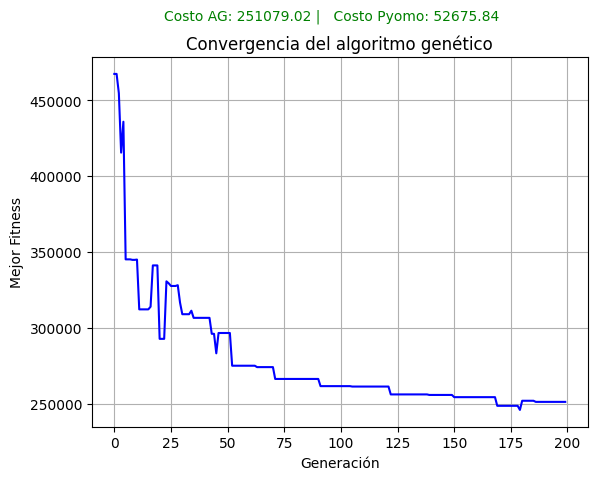

In [1099]:

import matplotlib.pyplot as plt

solo_costos = [t[1] for t in mejores_por_generacion]  # o usa t[1] si quieres el costo_real

plt.plot(solo_costos, color="blue")
plt.title("Convergencia del algoritmo genético")
plt.xlabel("Generación")
plt.ylabel("Mejor Fitness")
plt.grid(True)
plt.suptitle(f"Costo AG: {mejor_costo[1]:.2f} |   Costo Pyomo: 52675.84", fontsize=10, color="green")
plt.savefig("convergencia_AG_Proyecto_Prueba.png")
plt.show()


Evaluación

Selección

Cruce(recombinación)

Mutación

Reemplazo

Iteración